In [107]:
from PIL import Image
from numpy import *
from pylab import *
import ransac
import sift
from PIL import Image
import homography
import warp
from scipy import ndimage
import os
import scipy.misc

In [2]:
def Hsimilarity_from_points(fp, tp):
    """ Find similarity transformation, such that fp is mapped to tp
    using the linear DLT method. Points are conditioned
    automatically. """

    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')

    # Condition points (important for numerical reasons)
    # --from points--
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = dot(C1, fp)

    # -- to points --
    m = mean(tp[:2], axis=1)
    maxstd = max(std(tp[:2], axis=1)) + 1e-9
    C2 = diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = dot(C2, tp)

    # create matrix for linear method
    # Start from similarity transformation,
    # [x', y', 1].T = [[c, -s, tx], [s, c, ty], [0, 0, 1]] * [x, y, 1]
    # c = a*cos(t)
    # s = a*sin(t)
    # this can be extended to 
    # [[(x*y'-y*x'), -(x*x'+y*y'), y', -x']*[c, s, tx, ty]=[0, 0, 0].T
    # (.T is transverse)
    # By solving this for [(x, y, x', y') = [[x1, y1, x1', y1'], [x2, y2, x2', y2'], ...]
    # You can get c, s, tx, ty : similarity matrix
    nbr_correspondences = fp.shape[1]
    A = zeros((nbr_correspondences, 4))
    for i in range(nbr_correspondences):
        A[i] = [fp[0][i]*tp[1][i]-fp[1][i]*tp[0][i], -fp[0][i]*tp[0][i]-fp[1][i]*tp[1][i], tp[1][i], -tp[0][i]]
#        A[i] = [fp[1][i]*tp[0][i]-fp[0][i]*tp[1][i], -fp[1][i]*tp[1][i]-fp[0][i]*tp[0][i], tp[0][i], -tp[1][i]]
    U, S, V = linalg.svd(A)
    H = [[V[3][0], -V[3][1], V[3][2]], [V[3][1], V[3][0], V[3][3]], [0, 0, 1]]
        # V[3] has the smallest singlarity value = smallest error in least square method
    # decondition (C1, C2)
    H = dot(linalg.inv(C2), dot(H, C1))

    # normalize and return
    return H

In [176]:
class RansacModel_2(object):
    """ Class for testing homography fit with ransac.py from
    http://www.scipy.org/Cookbook/RANSAC
    This version uses Similarity Transformation 
    """

    def __init__(self, debug=False):
        self.debug = debug

    def fit(self, data):
        """ Fit homography to four selected correspondences. """

        data = data.T

        fp = data[:3, :4]

        tp = data[3:, :4]

#       return Hsimilarity_from_points(fp,tp)
        return homography.Haffine_from_points(fp,tp)

    def get_error(self, data, H):
        """ Apply homography to all correspondences,
        return error for each transformed point."""

        data = data.T

        fp = data[:3]
        tp = data[3:]


        fp_transformed = dot(H, fp)

        #
        nz = nonzero(fp_transformed[2])
        for i in range(3):
            fp_transformed[i][nz] /= fp_transformed[2][nz]

        return sqrt(sum((tp-fp_transformed)**2, axis=0))

In [177]:
# use the test data here
# http://www.cs.cornell.edu/courses/cs6670/2011sp/projects/p2/project2.html
# Yosemite set
# other files are here, but not used now
# http://www.cvl.isy.liu.se/en/research/datasets/passta/
def extract_matches(img1, img2):
    img_name = [os.path.splitext(img1)[0], os.path.splitext(img2)[0]]
    ext_name = [os.path.splitext(img1)[1], os.path.splitext(img2)[1]]
    featname = [img_name[i]+'.sift' for i in range(2)]
    iname = [img_name[i]+ext_name[i] for i in range(2)]
    l = {}
    d = {}
    for i in range(2):
        sift.process_image(iname[i],featname[i])
        l[i],d[i] = sift.read_features_from_file(featname[i])
        l[i][:,[0,1]] = l[i][:,[1,0]]
    
    matches = sift.match(d[1],d[0])
    return l, d, matches

In [178]:
def convert_points(matches, l):
    ndx = matches.nonzero()[0]
    fp = homography.make_homog(l[1][ndx, :2].T)
    ndx2 = [int(matches[i]) for i in ndx]
    tp = homography.make_homog(l[0][ndx2,:2].T)
    return fp, tp

processed tmp.pgm to ./yosemite_test/yosemite2.sift
processed tmp.pgm to ./yosemite_test/yosemite1.sift
processed tmp.pgm to ./yosemite_test/yosemite3.sift
processed tmp.pgm to tmpimg0.sift
processed tmp.pgm to ./yosemite_test/yosemite4.sift
processed tmp.pgm to tmpimg0.sift


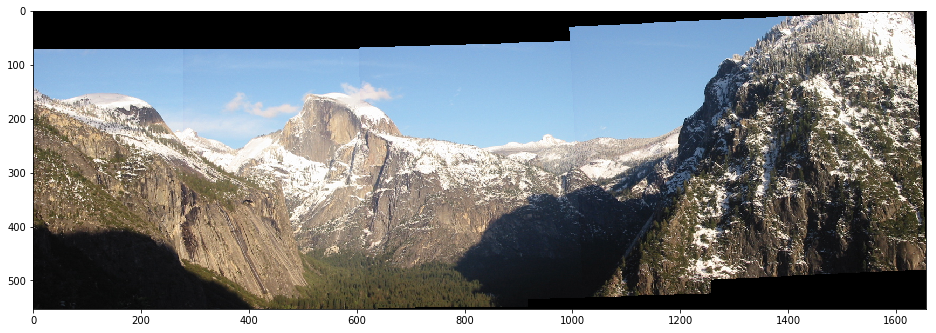

In [185]:
debug=False

imname = ['./yosemite_test/yosemite1.jpg', 
          './yosemite_test/yosemite2.jpg', 
          './yosemite_test/yosemite3.jpg', 
          './yosemite_test/yosemite4.jpg']
          
tmpname = 'tmpimg0.png'
    
first_img = True
for imn1 in range(0, 3):
    imname1 = imname[imn1] if (first_img) else tmpname
    im1 = array(Image.open(imname1)) # if (first_img) else im1_t
    first_img = False
    imn2 = imn1+1
    im2 = array(Image.open(imname[imn2]))
    l, d, matches = extract_matches(imname[imn2], imname1)
    fp, tp = convert_points(matches, l)
    
    model = RansacModel_2()
    # model = homography.RansacModel()
    H, inlier = homography.H_from_ransac(fp, tp, model)
    # print H

    m, n, c = im2.shape
    op = [[0, 0, m, m], [0, n, n, 0], [1, 1, 1, 1]]
    dp = dot(inv(H), op)

    ymax = int(max(dp[0]))
    ymin = int(min(dp[0]))
    xmax = int(max(dp[1]))
    xmin = int(min(dp[1]))

    xleft = 0 if (xmin>0) else -xmin
    xright = 0 if (xmax<im1.shape[1]) else (xmax-im1.shape[1])
    ytop = 0 if (ymin>0) else -ymin
    ybot = 0 if (ymax<im1.shape[0]) else (ymax-im1.shape[0])

    ty = -ytop
    tx = -xleft
    im1 = hstack((zeros((im1.shape[0], xleft, c)), im1, zeros((im1.shape[0], xright, c))))
    im1 = vstack((zeros((ytop, im1.shape[1], c)), im1, zeros((ybot, im1.shape[1], c))))
    
    if (debug==True):
        print "op\n", op
        print "dp\n", dp
        print 'ymax', ymax
        print 'ymin', ymin
        print 'xmax', xmax
        print 'xmin', xmin
        print 'ytop', ytop
        print 'ybot', ybot
        print 'xleft', xleft
        print 'xright', xright
        print "(tx, ty)", (tx, ty)
        print im1.shape
        print im2.shape
        
    H[0][2] += ty
    H[1][2] += tx
    
    def transf(p):
        p2 = dot(H, [p[0], p[1], 1])
        return (p2[0]/p2[2], p2[1]/p2[2])

    im2_t = zeros(im1.shape)
    for col in range(3):
        im2_t[:, :, col] = ndimage.geometric_transform(im2[:, :, col], 
                                                 transf, (im1.shape[0], im1.shape[1]))
    
    im1_t = zeros(im1.shape)
    alpha1 = (im2_t[:, :, 0] + im2_t[:, :, 1] + im2_t[:, :, 2])>0
#    alpha2 = (im1[:, :, 0]   + im1[:, :, 1]   + im1[:, :, 2])>0
#    alpha3 = zeros(alpha1.shape)
#    alpha3[alpha1] = 1
#    alpha3[alpha2] = alpha3[alpha2]+1
#    alpha3[alpha3==0] = 1
    
    for col in range(3):
#        im1_t[:, :, col] = (im2_t[:, :, col]*alpha1 + im1[:, :, col]*alpha2)/alpha3
        im1_t[:, :, col] = (im2_t[:, :, col]*alpha1 + im1[:, :, col]*(1-alpha1))
    
    if (debug):
        imshow(uint8(im1))
        show()
        imshow(uint8(im2))
        show()
        imshow(uint8(im2_t))
        show()
        imshow(uint8(im1_t))
        show()
    
    im1_t[im1_t<0] = 0
    im1_t[im1_t>255] = 255
    im1_t = uint8(im1_t)
    imname1 = tmpname
    scipy.misc.imsave(imname1, im1_t)
    
figure(figsize=(16, 16))
imshow(array(Image.open(imname1)))
show()